In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
import matplotlib as mpl
from jupyterthemes import jtplot #These two lines can be skipped if you are not using jupyter themes
jtplot.reset()

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.4, Om0=0.314)
import scipy as sp
import multiprocessing as mp

from matplotlib.ticker import StrMethodFormatter
import time
start_total = time.time()

In [2]:
from validity_class import sieplasma

In [3]:
import os
my_path = '/home/tomi/Documentos/Fisica/Tesis/escrito-tesis/images/'

In [4]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

In [5]:
zl = 0.2; zs = 1.2
Dl = cosmo.angular_diameter_distance(zl)   
Ds = cosmo.angular_diameter_distance(zs)    
Dls = cosmo.angular_diameter_distance_z1z2(zl, zs)
G = const.G
rho_crit = (cosmo.critical_density(zl)).to(u.kg/u.m**3)
c_light = (const.c).to(u.cm/u.second)

#r0 = 10*u.kpc
r0 = 10.0*u.kpc
#r0 = 0.1*u.kpc
pi = np.pi

def scale_radius(v,Dl,Ds,Dls):                               #this is e0 in eq 3.42 meneghetti, eq 1 barnacka 2014
    return (4.*pi*v**2/c_light**2*Dl*Dls/Ds).decompose()
def theta_E_SIS():
    'in arcsec'
    pre_theta_E = (scale_radius(v,Dl,Ds,Dls)/Dl).decompose()
    return pre_theta_E*u.rad.to('arcsec', equivalencies=u.dimensionless_angles()) 

v = 180 *u.km/u.s
ss_r = scale_radius(v,Dl,Ds,Dls) 
print('scale radius (m): ',ss_r)
print('scale radius (kpc): ',ss_r.to(u.kpc))
print('theta_E: ',theta_E_SIS() ,'arcsec')
theta_E_num = theta_E_SIS()
re = (const.e.esu**2/const.m_e/(c_light**2)).decompose()
print('Classic electron radius: ',re)

scale radius (m):  7.705329461274929e+19 m
scale radius (kpc):  2.49712721364453 kpc
theta_E:  0.7301786792241515 arcsec
Classic electron radius:  2.817940324670788e-15 m


In [6]:
nu = 130.0 * u.MHz
omega = nu*(1.+zl)*2*np.pi
n0 = 300./(u.cm)**(3)

In [7]:
theta_0 = (r0/Dl).decompose()*u.rad.to('arcsec', equivalencies=u.dimensionless_angles()) 
print('Angular scale radius (theta_0 = r0/Dl): ',theta_0, 'arcsec')

Angular scale radius (theta_0 = r0/Dl):  2.9240748137875747 arcsec


In [8]:
from lenstronomy.LensModel.Profiles.plasma_exponential_sie import PlasmaExponentialSIE
perfil = PlasmaExponentialSIE()

In [9]:
def image_position_3(x, y, eta):
    x_s, y_s = x, y
    x_pre, y_pre = lensEquationSolver.image_position_from_source(kwargs_lens=kwargs_lens_list, \
                    sourcePos_x=x_s, sourcePos_y=y_s, min_distance=0.05, search_window=5, \
                    precision_limit=10**(-8), num_iter_max=100,non_linear=True)
    print(x_pre)
    print(y_pre)
    mag = [0,0]
    t = [0,0]
    for k in range(len(x_pre)):
        mag[k] = lensModel.magnification(x_pre[k], y_pre[k], kwargs = kwargs_lens_list)
        phi = PlasmaExponentialSIE.function(perfil, x_pre[k], y_pre[k], theta_E_num.value, eta, A, B, C ,psi0_plasma.value, theta_0.value)
        t[k] = ((1+zl)/c_light*Ds*Dl/Dls*( 1/2*( (x_s - x_pre[k] )**2 + (y_s - y_pre[k])**2) - phi**2)*(u.arcsec**2).to('rad**2')).to('s').value
    r = np.abs(mag[0]/mag[1])
    rr = [r,r]
    dt = np.abs(t[0] - t[1])/24/60/60 #convert seconds to days
    dt = [dt,dt]
    return x_pre, y_pre, rr, dt

In [10]:
lens_model_list = ['PlasmaExponentialSIE']
lensModel = LensModel(lens_model_list)
lensEquationSolver = LensEquationSolver(lensModel)
A = 2.00744300029693
B = 1.5887225542022732
C = 1.4308204791467736
psi0_plasma = (A*Dls/Ds/Dl*2*pi*c_light**2/omega**2*re*n0*r0 \
            *(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) ).decompose()
psi0_plasma_num = psi0_plasma.value
theta_E_g = theta_E_SIS().value
theta_0_num = theta_0.value

In [42]:
eta_arr = np.linspace(.05, .25, 50)
r_arr = np.linspace(.2, .6, 50)
x_arr = y_arr = r_arr*np.cos(np.pi/4)

In [43]:
mag_p = np.zeros((50, 50))
for x in range(50):
    for i in range(50):
        sie_plasma = sieplasma(theta_E_g, eta_arr[i], zl, c_light.decompose().value, Dl.decompose().value, Ds.decompose().value, Dls.decompose().value, psi0_plasma_num, theta_0_num, B, C, 0.07, x_arr[x], x_arr[x])
        R = sie_plasma.R
        mag_p[x][i] = R

In [44]:
mag = np.zeros((50, 50))
for x in range(50):
    for i in range(50):
        kwargs = {'theta_E':theta_E_num.value,'eta':eta_arr[i], 'A':A, 'B':B, 'C':C ,'psi0_plasma':psi0_plasma.value,\
                        'theta_0':theta_0.value}
        kwargs_lens_list = [kwargs]
        x_image, y_image, r, dt = image_position_3(x_arr[x], x_arr[x], eta_arr[i])
        mag[x][i] = r[0]

[ 0.50078587 -0.38876161]
[ 0.71036066 -0.27254322]
[ 0.49235642 -0.39179512]
[ 0.71683817 -0.26726041]
[ 0.48410418 -0.39465452]
[ 0.72307941 -0.26203639]
[ 0.4760365  -0.39734249]
[ 0.72909017 -0.25687841]
[ 0.46815878 -0.39986236]
[ 0.73487724 -0.25179279]
[ 0.46047471 -0.40221802]
[ 0.7404482  -0.24678493]
[ 0.45298643 -0.4044138 ]
[ 0.74581115 -0.24185937]
[ 0.44569472 -0.40645437]
[ 0.75097456 -0.23701983]
[ 0.43859921 -0.40834468]
[ 0.75594711 -0.2322693 ]
[ 0.43169852 -0.41008984]
[ 0.76073755 -0.22761006]
[ 0.42499043 -0.41169509]
[ 0.76535457 -0.22304379]
[ 0.41847204 -0.4131657 ]
[ 0.76980673 -0.2185716 ]
[ 0.41213987 -0.41450697]
[ 0.77410243 -0.21419412]
[ 0.40599    -0.41572413]
[ 0.77824978 -0.20991153]
[ 0.40001817 -0.41682235]
[ 0.78225661 -0.20572361]
[ 0.39421983 -0.4178067 ]
[ 0.78613045 -0.20162985]
[ 0.38859028 -0.4186821 ]
[ 0.7898785  -0.19762942]
[ 0.38312466 -0.41945335]
[ 0.79350761 -0.19372126]
[ 0.37781807 -0.42012507]
[ 0.79702429 -0.1899041 ]
[ 0.37266556

[ 0.46105135 -0.38491311]
[ 0.77045825 -0.22600562]
[ 0.45454564 -0.38646787]
[ 0.77511028 -0.22188587]
[ 0.44820042 -0.387907  ]
[ 0.77961247 -0.21783311]
[ 0.44201418 -0.38923401]
[ 0.78397119 -0.21384883]
[ 0.43598492 -0.39045248]
[ 0.7881927  -0.20993417]
[ 0.43011022 -0.391566  ]
[ 0.79228317 -0.20608993]
[ 0.42438736 -0.39257818]
[ 0.79624863 -0.20231661]
[ 0.41881332 -0.39349259]
[ 0.80009493 -0.19861446]
[ 0.41338488 -0.39431277]
[ 0.80382773 -0.19498347]
[ 0.40809865 -0.39504219]
[ 0.8074525  -0.19142345]
[ 0.40295114 -0.39568425]
[ 0.81097448 -0.18793398]
[ 0.39793876 -0.39624227]
[ 0.81439868 -0.18451453]
[ 0.39305788 -0.39671949]
[ 0.8177299 -0.1811644]
[ 0.38830484 -0.39711903]
[ 0.82097274 -0.17788276]
[ 0.38367599 -0.39744394]
[ 0.82413154 -0.1746687 ]
[ 0.3791677  -0.39769713]
[ 0.82721044 -0.17152123]
[ 0.37477637 -0.39788144]
[ 0.8302134  -0.16843925]
[ 0.37049846 -0.39799958]
[ 0.83314413 -0.16542164]
[ 0.36633049 -0.39805415]
[ 0.83600617 -0.16246721]
[ 0.36226905 -

[ 0.43158402 -0.37131938]
[ 0.82198028 -0.18728461]
[ 0.42659591 -0.37191218]
[ 0.82548927 -0.18410563]
[ 0.421727   -0.37243097]
[ 0.82890854 -0.18098122]
[ 0.41697461 -0.37287818]
[ 0.83224203 -0.17791124]
[ 0.41233597 -0.37325618]
[ 0.83549355 -0.1748954 ]
[ 0.40780831 -0.3735673 ]
[ 0.83866673 -0.17193334]
[ 0.40338882 -0.37381379]
[ 0.84176508 -0.1690246 ]
[ 0.39907471 -0.37399787]
[ 0.84479194 -0.16616865]
[ 0.39486319 -0.37412166]
[ 0.84775051 -0.16336488]
[ 0.39075147 -0.37418724]
[ 0.85064385 -0.16061265]
[ 0.38673684 -0.37419663]
[ 0.85347486 -0.15791126]
[ 0.38281658 -0.37415175]
[ 0.85624632 -0.15525995]
[ 0.37898805 -0.37405449]
[ 0.85896088 -0.15265796]
[ 0.37524864 -0.37390664]
[ 0.86162104 -0.15010446]
[ 0.37159581 -0.37370995]
[ 0.86422921 -0.14759865]
[ 0.36802705 -0.37346609]
[ 0.86678766 -0.14513967]
[ 0.36453995 -0.37317668]
[ 0.86929855 -0.14272666]
[ 0.36113213 -0.37284325]
[ 0.87176395 -0.14035875]
[ 0.35780129 -0.37246731]
[ 0.8741858  -0.13803508]
[ 0.35454517

[ 0.41806328 -0.35072722]
[ 0.86275092 -0.15975823]
[ 0.41401726 -0.35078728]
[ 0.86566191 -0.15720786]
[ 0.41005987 -0.35079598]
[ 0.86851376 -0.15469892]
[ 0.40618889 -0.35075485]
[ 0.8713089  -0.15223103]
[ 0.40240218 -0.35066541]
[ 0.87404965 -0.14980375]
[ 0.39869758 -0.35052913]
[ 0.87673821 -0.14741662]
[ 0.39507298 -0.35034744]
[ 0.87937672 -0.14506914]
[ 0.39152631 -0.3501217 ]
[ 0.88196721 -0.14276079]
[ 0.38805551 -0.34985325]
[ 0.88451161 -0.14049102]
[ 0.38465861 -0.34954339]
[ 0.88701178 -0.13825928]
[ 0.38133362 -0.34919336]
[ 0.88946949 -0.136065  ]
[ 0.37807864 -0.34880437]
[ 0.89188643 -0.13390757]
[ 0.37489181 -0.34837759]
[ 0.89426422 -0.13178642]
[ 0.37177128 -0.34791412]
[ 0.89660439 -0.12970093]
[ 0.36871529 -0.34741507]
[ 0.89890842 -0.1276505 ]
[ 0.3657221  -0.34688146]
[ 0.9011777  -0.12563452]
[ 0.36279002 -0.3463143 ]
[ 0.90341359 -0.12365238]
[ 0.35991741 -0.34571456]
[ 0.90561735 -0.12170346]
[ 0.35710267 -0.34508318]
[ 0.9077902  -0.11978716]
[ 0.35434426

[ 0.41066711 -0.3268783 ]
[ 0.89999937 -0.13696809]
[ 0.40729114 -0.32657973]
[ 0.902525   -0.13487714]
[ 0.40398236 -0.32624351]
[ 0.90500948 -0.13281767]
[ 0.40073914 -0.32587065]
[ 0.90745434 -0.13078929]
[ 0.39755986 -0.32546212]
[ 0.90986103 -0.12879163]
[ 0.39444297 -0.32501887]
[ 0.91223098 -0.12682429]
[ 0.39138691 -0.32454183]
[ 0.91456552 -0.12488687]
[ 0.38839018 -0.32403187]
[ 0.91686596 -0.12297894]
[ 0.3854513  -0.32348986]
[ 0.91913351 -0.12110009]
[ 0.38256883 -0.32291664]
[ 0.92136938 -0.11924989]
[ 0.37974137 -0.32231301]
[ 0.92357469 -0.11742792]
[ 0.37696754 -0.32167974]
[ 0.92575053 -0.11563373]
[ 0.37424602 -0.3210176 ]
[ 0.92789795 -0.11386689]
[ 0.60343731 -0.29374237]
[ 0.76211679 -0.23197322]
[ 0.59689457 -0.29557941]
[ 0.76768994 -0.22906709]
[ 0.59041488 -0.29734749]
[ 0.77315022 -0.22615771]
[ 0.58400376 -0.29904611]
[ 0.77849677 -0.22324791]
[ 0.57766621 -0.30067492]
[ 0.78372926 -0.22034039]
[ 0.5714067  -0.30223376]
[ 0.78884782 -0.21743777]
[ 0.56522917

[ 0.3989097  -0.29917389]
[ 0.94174819 -0.11230928]
[ 0.62462126 -0.27375052]
[ 0.77577619 -0.21991131]
[ 0.61837911 -0.27537047]
[ 0.78117203 -0.217365  ]
[ 0.61218869 -0.27693288]
[ 0.7864703  -0.21481195]
[ 0.60605491 -0.27843722]
[ 0.79166988 -0.21225439]
[ 0.59998229 -0.27988307]
[ 0.79677003 -0.2096945 ]
[ 0.59397492 -0.28127013]
[ 0.80177043 -0.20713435]
[ 0.5880365  -0.28259825]
[ 0.80667112 -0.20457598]
[ 0.58217032 -0.28386736]
[ 0.81147247 -0.20202131]
[ 0.57637928 -0.28507749]
[ 0.81617514 -0.1994722 ]
[ 0.57066588 -0.28622881]
[ 0.82078008 -0.1969304 ]
[ 0.56503229 -0.28732155]
[ 0.82528847 -0.19439757]
[ 0.5594803  -0.28835603]
[ 0.8297017 -0.1918753]
[ 0.5540114  -0.28933268]
[ 0.83402135 -0.18936507]
[ 0.54862675 -0.29025196]
[ 0.83824915 -0.18686826]
[ 0.54332723 -0.29111444]
[ 0.84238696 -0.18438618]
[ 0.53811345 -0.29192072]
[ 0.84643675 -0.18192004]
[ 0.53298578 -0.29267148]
[ 0.85040057 -0.17947096]
[ 0.52794438 -0.29336744]
[ 0.85428055 -0.17703997]
[ 0.52298916 -

[ 0.60446293 -0.2631623 ]
[ 0.82465629 -0.19152718]
[ 0.59886772 -0.26423799]
[ 0.82927772 -0.18926846]
[ 0.59333939 -0.26526336]
[ 0.83381167 -0.18701233]
[ 0.58788013 -0.2662385 ]
[ 0.83825885 -0.18476019]
[ 0.5824918  -0.26716352]
[ 0.84262014 -0.18251341]
[ 0.577176   -0.26803864]
[ 0.84689663 -0.18027326]
[ 0.57193406 -0.26886412]
[ 0.85108953 -0.17804097]
[ 0.56676708 -0.26964028]
[ 0.85520021 -0.17581768]
[ 0.56167591 -0.27036749]
[ 0.85923013 -0.17360448]
[ 0.55666118 -0.27104617]
[ 0.86318087 -0.17140241]
[ 0.55172332 -0.27167679]
[ 0.86705406 -0.16921243]
[ 0.54686257 -0.27225986]
[ 0.87085143 -0.16703542]
[ 0.54207901 -0.27279591]
[ 0.87457472 -0.16487224]
[ 0.53737255 -0.27328552]
[ 0.87822573 -0.16272364]
[ 0.53274295 -0.2737293 ]
[ 0.88180628 -0.16059037]
[ 0.52818985 -0.27412786]
[ 0.88531822 -0.15847307]
[ 0.52371278 -0.27448186]
[ 0.88876338 -0.15637234]
[ 0.51931114 -0.27479197]
[ 0.89214361 -0.15428875]
[ 0.51498426 -0.27505887]
[ 0.89546072 -0.1522228 ]
[ 0.51073138

[ 0.57004001 -0.25100699]
[ 0.88396324 -0.15849303]
[ 0.56534293 -0.25148445]
[ 0.88768227 -0.15654433]
[ 0.56071551 -0.25192077]
[ 0.89133378 -0.15460546]
[ 0.55615776 -0.25231636]
[ 0.89491924 -0.1526771 ]
[ 0.55166959 -0.25267166]
[ 0.89844017 -0.1507599 ]
[ 0.54725076 -0.25298712]
[ 0.90189809 -0.14885446]
[ 0.54290097 -0.25326324]
[ 0.90529455 -0.14696133]
[ 0.53861978 -0.25350049]
[ 0.90863108 -0.14508103]
[ 0.53440672 -0.25369939]
[ 0.91190925 -0.14321404]
[ 0.53026119 -0.25386046]
[ 0.91513058 -0.1413608 ]
[ 0.52618256 -0.25398423]
[ 0.91829661 -0.13952172]
[ 0.52217012 -0.25407125]
[ 0.92140884 -0.13769715]
[ 0.51822313 -0.25412207]
[ 0.92446877 -0.13588745]
[ 0.51434077 -0.25413724]
[ 0.92747787 -0.1340929 ]
[ 0.51052222 -0.25411731]
[ 0.93043759 -0.13231378]
[ 0.50676659 -0.25406285]
[ 0.93334935 -0.13055033]
[ 0.50307299 -0.25397441]
[ 0.93621454 -0.12880277]
[ 0.49944049 -0.25385257]
[ 0.93903452 -0.12707127]
[ 0.49586815 -0.25369787]
[ 0.94181062 -0.12535601]
[ 0.49235499

[ 0.54934582 -0.23276153]
[ 0.93177691 -0.13200559]
[ 0.54536244 -0.23282682]
[ 0.93491127 -0.13034273]
[ 0.54143997 -0.23285915]
[ 0.93799541 -0.12869092]
[ 0.53757782 -0.23285896]
[ 0.9410306  -0.12705048]
[ 0.53377534 -0.23282666]
[ 0.94401813 -0.12542173]
[ 0.53003185 -0.23276269]
[ 0.94695925 -0.12380494]
[ 0.52634663 -0.23266747]
[ 0.9498552  -0.12220037]
[ 0.52271893 -0.23254146]
[ 0.95270721 -0.12060825]
[ 0.519148   -0.23238507]
[ 0.95551647 -0.11902879]
[ 0.51563304 -0.23219877]
[ 0.95828415 -0.11746219]
[ 0.51217324 -0.23198298]
[ 0.9610114  -0.11590861]
[ 0.50876778 -0.23173815]
[ 0.96369934 -0.1143682 ]
[ 0.50541582 -0.23146471]
[ 0.96634908 -0.11284111]
[ 0.50211653 -0.23116311]
[ 0.96896168 -0.11132743]
[ 0.49886905 -0.23083376]
[ 0.97153819 -0.10982728]
[ 0.49567254 -0.23047712]
[ 0.97407962 -0.10834072]
[ 0.49252615 -0.23009359]
[ 0.97658696 -0.10686784]
[ 0.48942901 -0.22968361]
[ 0.97906119 -0.10540868]
[ 0.48638028 -0.22924759]
[ 0.98150323 -0.10396328]
[ 0.48337911

[ 0.53844693 -0.21121474]
[ 0.97219134 -0.11044877]
[ 0.53498808 -0.21099498]
[ 0.97494807 -0.10902294]
[ 0.53158078 -0.2107483 ]
[ 0.9776664  -0.10760736]
[ 0.52822433 -0.21047504]
[ 0.98034732 -0.10620219]
[ 0.52491802 -0.21017555]
[ 0.98299183 -0.1048076 ]
[ 0.52166112 -0.20985017]
[ 0.98560087 -0.10342373]
[ 0.51845291 -0.20949926]
[ 0.98817538 -0.10205069]
[ 0.51529266 -0.20912316]
[ 0.99071628 -0.10068861]
[ 0.51217961 -0.20872221]
[ 0.99322447 -0.09933757]
[ 0.50911304 -0.20829676]
[ 0.99570082 -0.09799768]
[ 0.50609219 -0.20784714]
[ 0.99814618 -0.096669  ]
[ 0.50311633 -0.20737369]
[ 1.00056137 -0.0953516 ]
[ 0.50018471 -0.20687675]
[ 1.0029472  -0.09404553]
[ 0.71123031 -0.19183097]
[ 0.83898407 -0.16240243]
[ 0.70594633 -0.19271997]
[ 0.84375904 -0.16097094]
[ 0.70068745 -0.19357952]
[ 0.84847737 -0.1595287 ]
[ 0.69545664 -0.19440926]
[ 0.85313776 -0.15807655]
[ 0.69025677 -0.19520887]
[ 0.85773905 -0.15661535]
[ 0.68509052 -0.19597807]
[ 0.8622803  -0.15514594]
[ 0.67996043

[ 0.52249714 -0.18622556]
[ 1.01735802 -0.08765322]
[ 0.73041774 -0.17374959]
[ 0.85422853 -0.14838718]
[ 0.72529786 -0.1745082 ]
[ 0.85888882 -0.14714157]
[ 0.72019977 -0.17524102]
[ 0.8634983  -0.14588535]
[ 0.71512615 -0.17594775]
[ 0.86805569 -0.14461921]
[ 0.71007958 -0.17662809]
[ 0.87255988 -0.14334385]
[ 0.70506251 -0.17728179]
[ 0.8770099  -0.14205995]
[ 0.70007726 -0.17790862]
[ 0.88140493 -0.14076819]
[ 0.69512603 -0.17850837]
[ 0.88574433 -0.13946924]
[ 0.69021088 -0.17908085]
[ 0.89002756 -0.13816377]
[ 0.68533374 -0.17962591]
[ 0.89425424 -0.13685243]
[ 0.6804964  -0.18014341]
[ 0.89842412 -0.13553588]
[ 0.67570051 -0.18063323]
[ 0.90253708 -0.13421473]
[ 0.6709476  -0.18109529]
[ 0.90659308 -0.13288962]
[ 0.66623905 -0.18152952]
[ 0.91059224 -0.13156114]
[ 0.66157613 -0.18193588]
[ 0.91453475 -0.13022991]
[ 0.65695997 -0.18231433]
[ 0.91842088 -0.12889649]
[ 0.65239157 -0.18266488]
[ 0.92225103 -0.12756146]
[ 0.64787184 -0.18298753]
[ 0.92602564 -0.12622537]
[ 0.64340155

[ 0.69148943 -0.16204228]
[ 0.9210739  -0.12071158]
[ 0.68688448 -0.16239545]
[ 0.92502583 -0.1195458 ]
[ 0.68232072 -0.16272392]
[ 0.92892547 -0.1183762 ]
[ 0.67779927 -0.16302763]
[ 0.93277297 -0.1172033 ]
[ 0.67332114 -0.16330657]
[ 0.93656857 -0.11602757]
[ 0.66888724 -0.1635607 ]
[ 0.94031256 -0.11484948]
[ 0.66449837 -0.16379003]
[ 0.94400534 -0.11366951]
[ 0.66015524 -0.16399458]
[ 0.94764733 -0.1124881 ]
[ 0.65585846 -0.16417437]
[ 0.95123902 -0.11130569]
[ 0.65160856 -0.16432943]
[ 0.95478096 -0.11012271]
[ 0.64740597 -0.16445984]
[ 0.95827375 -0.10893958]
[ 0.64325106 -0.16456564]
[ 0.96171801 -0.10775671]
[ 0.63914409 -0.16464693]
[ 0.96511442 -0.10657447]
[ 0.63508528 -0.16470378]
[ 0.96846366 -0.10539326]
[ 0.63107476 -0.16473631]
[ 0.97176647 -0.10421344]
[ 0.6271126  -0.16474462]
[ 0.9750236  -0.10303537]
[ 0.62319881 -0.16472884]
[ 0.97823582 -0.10185937]
[ 0.61933335 -0.16468908]
[ 0.98140391 -0.1006858 ]
[ 0.61551612 -0.16462549]
[ 0.98452866 -0.09951495]
[ 0.61174696

[ 0.66434892 -0.14514143]
[ 0.97608865 -0.09686566]
[ 0.6602971  -0.14517475]
[ 0.97947488 -0.09582099]
[ 0.65628989 -0.14518607]
[ 0.9828165 -0.094776 ]
[ 0.65232749 -0.14517546]
[ 0.98611413 -0.093731  ]
[ 0.64841006 -0.14514297]
[ 0.98936839 -0.09268632]
[ 0.64453768 -0.1450887 ]
[ 0.99257993 -0.09164227]
[ 0.64071039 -0.14501273]
[ 0.99574942 -0.09059915]
[ 0.63692818 -0.14491514]
[ 0.99887753 -0.08955725]
[ 0.63319099 -0.14479604]
[ 1.00196498 -0.08851684]
[ 0.62949871 -0.14465555]
[ 1.00501245 -0.08747821]
[ 0.62585119 -0.14449375]
[ 1.00802067 -0.0864416 ]
[ 0.62224826 -0.14431079]
[ 1.01099036 -0.08540728]
[ 0.61868968 -0.14410678]
[ 1.01392224 -0.08437549]
[ 0.61517522 -0.14388186]
[ 1.01681702 -0.08334646]
[ 0.61170458 -0.14363614]
[ 1.01967545 -0.08232041]
[ 0.60827746 -0.14336978]
[ 1.02249824 -0.08129757]
[ 0.60489352 -0.14308292]
[ 1.02528611 -0.08027814]
[ 0.60155241 -0.1427757 ]
[ 1.02803978 -0.07926231]
[ 0.59825376 -0.14244827]
[ 1.03075995 -0.07825028]
[ 0.59499715 -

[ 0.65066733 -0.12522681]
[ 1.01952728 -0.07734374]
[ 0.64704712 -0.12503623]
[ 1.02254101 -0.07642522]
[ 0.6434689  -0.12482634]
[ 1.02551771 -0.0755077 ]
[ 0.63993252 -0.12459724]
[ 1.02845801 -0.07459142]
[ 0.63643782 -0.12434903]
[ 1.03136257 -0.07367659]
[ 0.63298458 -0.12408179]
[ 1.03423201 -0.07276343]
[ 0.62957257 -0.12379564]
[ 1.03706699 -0.07185214]
[ 0.62620154 -0.12349067]
[ 1.03986815 -0.07094291]
[ 0.6228712  -0.12316699]
[ 1.04263614 -0.07003594]
[ 0.61958125 -0.12282472]
[ 1.04537159 -0.06913142]
[ 0.61633137 -0.12246397]
[ 1.04807514 -0.06822951]
[ 0.61312121 -0.12208487]
[ 1.05074743 -0.0673304 ]
[ 0.60995043 -0.12168752]
[ 1.05338908 -0.06643424]
[ 0.60681864 -0.12127205]
[ 1.05600071 -0.06554119]
[ 0.60372547 -0.1208386 ]
[ 1.05858294 -0.0646514 ]
[ 0.60067052 -0.12038728]
[ 1.06113638 -0.06376502]
[ 0.59765339 -0.11991822]
[ 1.06366162 -0.06288219]
[ 0.59467365 -0.11943156]
[ 1.06615926 -0.06200304]
[ 0.79306393 -0.1152293 ]
[ 0.90621341 -0.10075302]
[ 0.78839024

[ 0.64064708 -0.10354508]
[ 1.06010339 -0.05960871]
[ 0.63740599 -0.10316974]
[ 1.06282039 -0.05880918]
[ 0.63420281 -0.1027775 ]
[ 1.06550697 -0.05801132]
[ 0.63103725 -0.10236847]
[ 1.06816371 -0.05721529]
[ 0.62790899 -0.10194273]
[ 1.07079116 -0.05642125]
[ 0.62481771 -0.10150039]
[ 1.0733899  -0.05562934]
[ 0.62176308 -0.10104154]
[ 1.07596047 -0.05483971]
[ 0.61874476 -0.10056629]
[ 1.07850344 -0.05405249]
[ 0.61576237 -0.10007473]
[ 1.08101934 -0.05326782]
[ 0.81155748 -0.09818323]
[ 0.92208913 -0.0863441 ]
[ 0.80699378 -0.09849281]
[ 0.9263427  -0.08571575]
[ 0.80244293 -0.09878688]
[ 0.93056266 -0.08507852]
[ 0.79790672 -0.0990653 ]
[ 0.934748  -0.0844327]
[ 0.79338687 -0.09932789]
[ 0.93889776 -0.08377861]
[ 0.78888505 -0.09957452]
[ 0.94301107 -0.08311654]
[ 0.78440287 -0.09980503]
[ 0.94708716 -0.08244679]
[ 0.77994189 -0.10001931]
[ 0.95112531 -0.08176967]
[ 0.7755036  -0.10021722]
[ 0.95512491 -0.08108547]
[ 0.77108941 -0.10039865]
[ 0.95908542 -0.0803945 ]
[ 0.76670067 -

[ 0.82548188 -0.08161904]
[ 0.94224585 -0.07143768]
[ 0.82103096 -0.08183288]
[ 0.94639151 -0.07091069]
[ 0.81659325 -0.08203265]
[ 0.95050532 -0.07037556]
[ 0.81217034 -0.08221821]
[ 0.95458637 -0.06983255]
[ 0.80776376 -0.08238944]
[ 0.95863384 -0.0692819 ]
[ 0.80337501 -0.08254621]
[ 0.96264695 -0.06872387]
[ 0.79900552 -0.08268842]
[ 0.96662502 -0.06815871]
[ 0.79465668 -0.08281594]
[ 0.97056743 -0.06758668]
[ 0.79032982 -0.08292868]
[ 0.97447364 -0.06700803]
[ 0.78602621 -0.08302653]
[ 0.97834316 -0.06642301]
[ 0.78174705 -0.08310942]
[ 0.98217558 -0.06583186]
[ 0.77749349 -0.08317724]
[ 0.98597056 -0.06523485]
[ 0.77326662 -0.08322993]
[ 0.98972781 -0.06463221]
[ 0.76906747 -0.08326741]
[ 0.9934471 -0.0640242]
[ 0.76489701 -0.08328962]
[ 0.99712826 -0.06341106]
[ 0.76075612 -0.08329649]
[ 1.00077119 -0.06279303]
[ 0.75664567 -0.08328798]
[ 1.00437583 -0.06217036]
[ 0.75256643 -0.08326403]
[ 1.00794216 -0.06154328]
[ 0.74851911 -0.08322461]
[ 1.01147023 -0.06091204]
[ 0.7445044  -

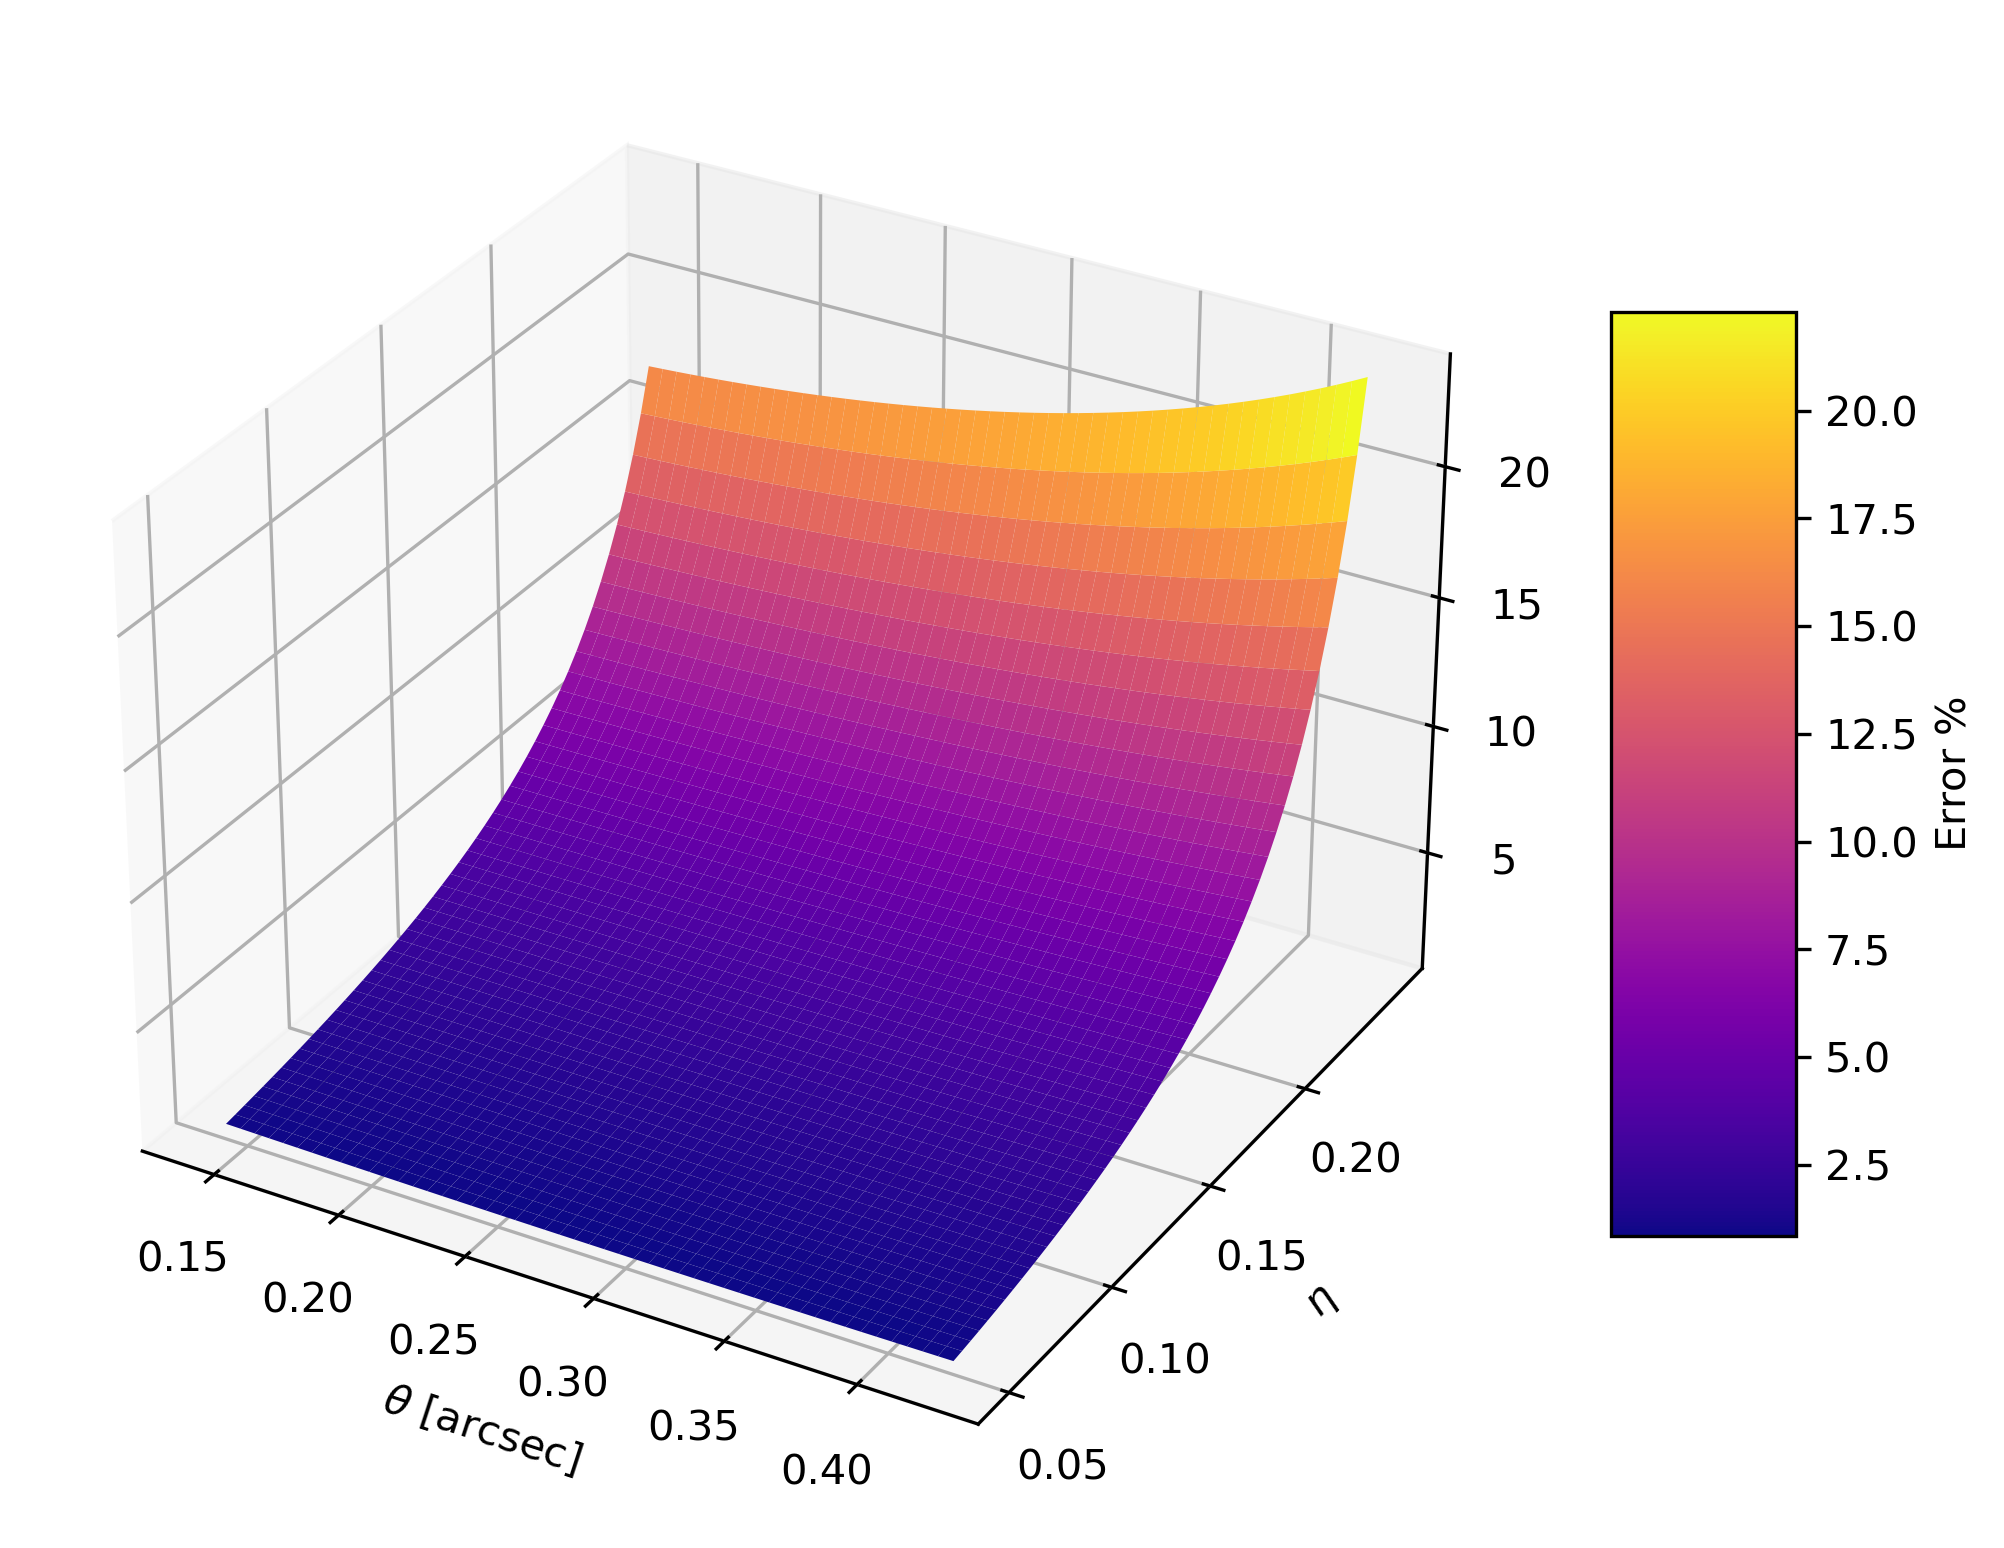

In [65]:
X, Eta = np.meshgrid(x_arr, eta_arr)
error = np.abs(mag - mag_p)/mag_p*100
fig = plt.figure(figsize=(8,8), dpi = 300)
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Eta, error, cmap='plasma')
cbar = fig.colorbar(surf, shrink=0.5, aspect=5)
cbar.set_label('Error $\%$')
ax.set_xlabel(r'$\theta$ [arcsec]') #to be constistent with our first convention (sorry for the mess)
ax.set_ylabel(r'$\eta$')
ax.set_yticks(np.arange(.05, .25, .05))
plt.show()

In [17]:
end_total = time.time()
print('total time: ',(end_total-start_total)/60.,' minutes')

total time:  1.8482361674308776  minutes
